In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
from tqdm import trange

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
device = 'cuda' if torch.cuda.is_available() == True else 'cpu'
print(device)

cuda


In [3]:
def preprocessing_text(sen, stop_words):
    sentence = remove_tags(sen)
    sentence = sentence.lower()
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    sentence = re.sub(r'\s+', ' ', sentence)
    new_sentence = ''
    for i in sentence.split(' '):
        if i not in stop_words and len(i) > 1:
            new_sentence = new_sentence + ' ' + i
    return new_sentence

def remove_tags(text):
    TAG_RE = re.compile(r'<[^>]+>')
    return TAG_RE.sub('', text)

def preprocessing_list_of_sentences(sentences_list):
    stop_words = set(stopwords.words('english'))
    reviews_processed = list()
    for sen in sentences_list:
        reviews_processed.append(preprocessing_text(sen, stop_words))
    return reviews_processed

In [4]:
data = pd.read_csv(r"E:\Data\yelp_reviews\shuffled_reviews_with_splits_full.csv")

In [5]:
rating = list(data.rating)
review = list(data.review)

In [6]:
review = preprocessing_list_of_sentences(review)

In [7]:
def splitting_data(dataset):
    train = dataset[0:int(len(dataset)*0.8)]
    test = dataset[int(len(dataset)*0.8):]
    return train, test

In [8]:
x_train, x_test = splitting_data(review)
y_train, y_test = splitting_data(rating)
len(x_train), len(x_test), len(y_train), len(y_test)

(478400, 119600, 478400, 119600)

In [9]:
class Vocabulary():
    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test
        
    def word_freq(self):
        frequency = dict()
        for sen in self.x_train:
            for word in sen.split(' '):
                if word != '':
                    try:
                        frequency[word] += 1
                    except:
                        frequency[word] = 1 
        return frequency
    
    def padding(self, x_train_f, max_len):
        output = list()
            
        for index in range(len(x_train_f)):
            if len(x_train_f[index]) > max_len:
                output.append(x_train_f[index][:max_len])
            elif len(x_train_f[index]) < max_len:
                put = x_train_f[index].copy()
                add = max_len - len(x_train_f[index])
                for _ in range(add):
                    put.append(0)
                output.append(put)
            elif len(x_train_f[index]) == max_len:
                output.append(x_train_f[index])
        return output
    
    def sen_to_freq(self, x_train, freq):
        output = list()
        for _ in x_train:
            output.append(list())
        
        for index in range(len(x_train)):
            for word in x_train[index].split(' '):
                if word != '':
                    try:
                        output[index].append(freq[word])
                    except:
                        continue
        return output
    
    def length_dataframe(self, x_train_f):
        length = list()
        for i in range(len(x_train_f)):
            length.append(len(x_train_f[i]))
        df = pd.DataFrame(length)
        print(df.describe())

In [10]:
vocab = Vocabulary(x_train, x_test, y_train, y_test)
freq = vocab.word_freq()

x_train_f = vocab.sen_to_freq(x_train, freq)
x_test_f = vocab.sen_to_freq(x_test, freq)

print('Length of Train:')
vocab.length_dataframe(x_train_f)
print('Length of Test')
vocab.length_dataframe(x_test_f)

x_train_p = vocab.padding(x_train_f, 80)
x_test_p = vocab.padding(x_test_f, 80)

print('Length of Padded Train:')
vocab.length_dataframe(x_train_p)
print('Length of Padded Test:')
vocab.length_dataframe(x_test_p)

Length of Train:
                   0
count  478400.000000
mean       66.742007
std        60.591225
min         0.000000
25%        26.000000
50%        49.000000
75%        87.000000
max       656.000000
Length of Test
                   0
count  119600.000000
mean       66.545543
std        60.626474
min         0.000000
25%        26.000000
50%        48.000000
75%        87.000000
max       516.000000
Length of Padded Train:
              0
count  478400.0
mean       80.0
std         0.0
min        80.0
25%        80.0
50%        80.0
75%        80.0
max        80.0
Length of Padded Test:
              0
count  119600.0
mean       80.0
std         0.0
min        80.0
25%        80.0
50%        80.0
75%        80.0
max        80.0


In [11]:
x_train_t = torch.tensor(x_train_p)
x_test_t = torch.tensor(x_test_p)
x_train_t.shape, x_test_t.shape

(torch.Size([478400, 80]), torch.Size([119600, 80]))

In [12]:
y_train_b = list(map(lambda x: 1 if x == 'positive' else 0, y_train))
y_test_b = list(map(lambda x: 1 if x == 'positive' else 0, y_test))

y_train_t = torch.tensor(y_train_b)
y_test_t = torch.tensor(y_test_b)
y_train_t.shape, y_test_t.shape

(torch.Size([478400]), torch.Size([119600]))

In [13]:
num_embeddings = int(torch.max(torch.tensor(list(freq.values()))))

In [14]:
class Net(nn.Module):
    def __init__(self, num_embeddings):
        super(Net, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=num_embeddings+1, embedding_dim=80)
        self.conv1d_1 = nn.Conv1d(80, 32, kernel_size=4)
        self.conv1d_2 = nn.Conv1d(80, 32, kernel_size=6)
        self.conv1d_3 = nn.Conv1d(80, 32, kernel_size=8)
        self.dropout = nn.Dropout(0.5)
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.linear_1 = nn.Linear(3552, 10)
        self.linear_2 = nn.Linear(10, 1)
        
    def forward(self, x):
        # First Channel
        out1 = F.relu(self.conv1d_1(self.embedding(x)))
        out1 = self.flatten(self.maxpool(self.dropout(out1)))
        
        # Second Channel
        out2 = F.relu(self.conv1d_2(self.embedding(x)))
        out2 = self.flatten(self.maxpool(self.dropout(out2)))
        
        # Third Channel
        out3 = F.relu(self.conv1d_3(self.embedding(x)))
        out3 = self.flatten(self.maxpool(self.dropout(out3)))
        
        # Merging
        merge = torch.cat([out1, out2, out3], dim=1)
        
        # Merged output
        out = F.relu(self.linear_1(merge))
        out = torch.sigmoid(self.linear_2(out))
        
        return out

100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [10:24<00:00, 24.01it/s]


(0.0, 1.1)

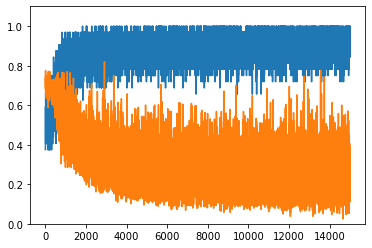

In [22]:
model = Net(num_embeddings).to(device=device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
losses, accuracies = list(), list()
bs = 32

for epoch in (t := trange(15000)):
    samp = np.random.randint(0, x_train_t.shape[0], size=(bs))
    x = x_train_t[samp].to(device=device)
    y = y_train_t[samp].float().to(device=device)
    model.zero_grad()
    out = model(x).view(32)
    cat = torch.tensor(list(map(lambda x: 1 if x > 0.5 else 0, out))).to(device=device)
    acc = (cat == y).float().mean()
    loss = loss_fn(out, y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    accuracies.append(acc.item())
    
plt.plot(accuracies)
plt.plot(losses)
plt.ylim(0, 1.1)

In [23]:
for name, x, y in [('train', x_train_t, y_train_t), ('test', x_test_t, y_test_t)]:
    iterations = len(x)//32
    accuracies = list()
    start, end = 0, 0
    for epoch in (t := trange(iterations)):
        with torch.no_grad():
            end += 32
            try:
                x_ = x[start:end].to(device=device)
                y_ = y[start:end].to(device=device)
            except:
                x_ = x[start:].to(device=device)
                y_ = y[start:].to(device=device)
            start += 32
            out = model(x_).view(32)
            cat = torch.tensor(list(map(lambda a: 1 if a > 0.5 else 0, out))).to(device=device)
            accuracy = (cat == y_).float()
            for acc in accuracy:
                accuracies.append(acc.item())
    print(name, 'accuracy: ', np.array(accuracies).mean()*100)

  0%|▍                                                                              | 18/3737 [00:00<00:20, 178.22it/s]

train accuracy:  90.1626254180602


100%|█████████████████████████████████████████████████████████████████████████████| 3737/3737 [00:24<00:00, 155.58it/s]

test accuracy:  89.55964008563019
